<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Download-das-bibliotecas" data-toc-modified-id="Download-das-bibliotecas-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Download das bibliotecas</a></span></li><li><span><a href="#Construção-do-Modelo" data-toc-modified-id="Construção-do-Modelo-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Construção do Modelo</a></span></li><li><span><a href="#Otimização-dos-Parâmetros" data-toc-modified-id="Otimização-dos-Parâmetros-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Otimização dos Parâmetros</a></span></li><li><span><a href="#Variação-dos-parametros" data-toc-modified-id="Variação-dos-parametros-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Variação dos parametros</a></span></li></ul></div>

## Download das bibliotecas

In [1]:
using Pkg
Pkg.activate("..")
Pkg.status()

Activating environment at `~/Documents/modelo-covid19/Project.toml`
    Status `~/Documents/modelo-covid19/Project.toml`
  [864edb3b] DataStructures v0.17.15
  [aae7a2af] DiffEqFlux v1.9.0
  [1130ab10] DiffEqParamEstim v1.14.0
  [41bf760c] DiffEqSensitivity v6.13.0
  [ef61062a] DiffEqUncertainty v1.4.1
  [0c46a032] DifferentialEquations v6.13.0
  [31c24e10] Distributions v0.21.12
  [587475ba] Flux v0.10.4
  [1b10255b] GlobalSensitivityAnalysis v0.0.10
  [429524aa] Optim v0.20.6
  [1dea7af3] OrdinaryDiffEq v5.35.5
  [65888b18] ParameterizedFunctions v5.3.0
  [91a5bcdd] Plots v1.2.4
  [438e738f] PyCall v1.91.4
  [d330b81b] PyPlot v2.9.0
  [8a4e6c94] QuasiMonteCarlo v0.2.0
  [e88e6eb3] Zygote v0.4.19


In [2]:
include("../src/dados.jl");

In [3]:
include("../src/models.jl");

In [4]:
include("../src/graphs.jl");

In [5]:
include("../src/parametrization.jl");

In [6]:
include("../src/optimization.jl");

## Construção do Modelo

In [7]:
Ts = 0.0:1.0:float(n_pts)
sol = model(params_rio_base, CI_Rio, Ts);

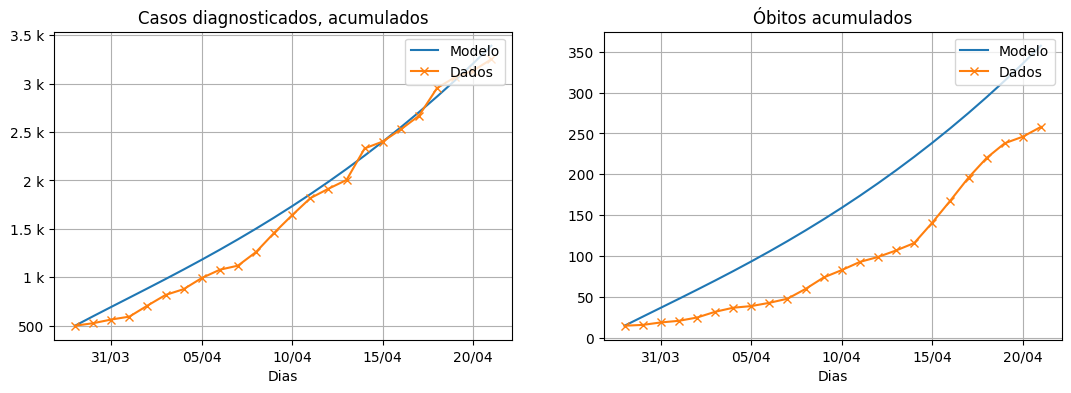

In [8]:
fig, axs = PyPlot.subplots(ncols=2, figsize=(13,4))
datas = [Rio_acc_d,Rio_acc_m]
series = [sol[9,:],sol[10,:]]
axs[1].set_title("Casos diagnosticados, acumulados")
axs[2].set_title("Óbitos acumulados")
for (ax,serie,data) in zip(axs,series,datas)
    graph_py.plot_accum(serie, data,real_data = true, ax = ax,blur = 1.0, cor_serie = "C0", cor_dados = "C1x-")
end

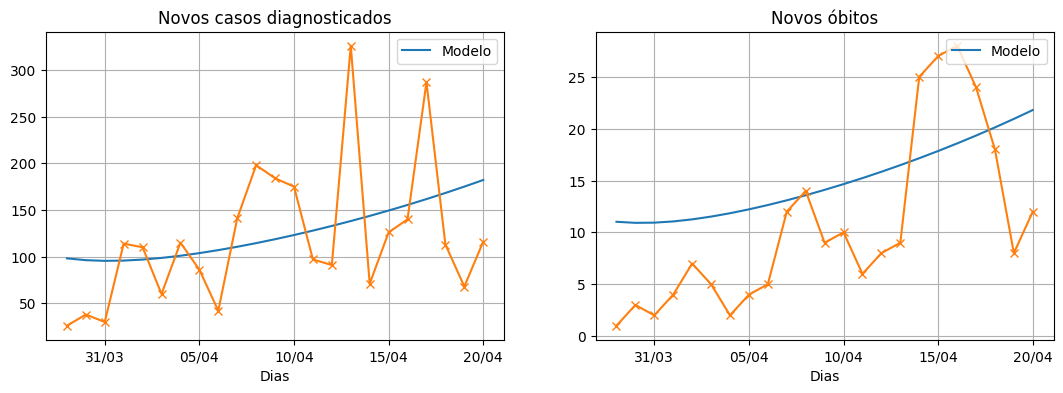

In [9]:
fig, axs = PyPlot.subplots(ncols=2, figsize=(13,4))
datas = [diagn_Rio,obitos_Rio]
series = [sol[9,:],sol[10,:]]
axs[1].set_title("Novos casos diagnosticados")
axs[2].set_title("Novos óbitos")
for (ax,serie,data) in zip(axs,series,datas)
    graph_py.plot_daily(serie, data,real_data = true, ax = ax, cor_serie = "C0", cor_dados = "C1x-")
end

## Otimização dos Parâmetros

In [10]:
pp_p_ci(p_start)

População em quarentena = 4.0313418e6 = 60.0 %
          Exposta       = 3486.0
          Assintom      = 160.25940011462774
          Sintomática   = 1175.2356008406034
    
Taxa de contágio    = 2.1268425120951884
Fator cont assintom = 0.1
Em quarentena       = 60.0 % 
Prop sintomática    = 0.88
Taxa testagem A     = 0.01 ~ 100.0 dias
Taxa testagem I     = 0.03333333333333333 ~ 30.0 dias


In [11]:
loss_obj(p_start)

339838.65687845246

In [12]:
res = DiffEqFlux.sciml_train(loss_adjoint, p_start, Fminbox(LBFGS()),
    lower_bounds=[0.0, 0.01, 0.4, 0.88, 0, 0.2, 2], upper_bounds=[1e-6, 0.2, 0.7, 0.94, 0.4, 0.6, 50])
#    cb = cb)

┌ Warning: Initial position cannot be on the boundary of the box. Moving elements to the interior.
│ Element indices affected: [4]
└ @ Optim /home/rafael/.julia/packages/Optim/UkDyx/src/multivariate/solvers/constrained/fminbox.jl:227


 * Status: success

 * Candidate solution
    Minimizer: [8.55e-08, 2.00e-01, 6.23e-01,  ...]
    Minimum:   3.303655e+05

 * Found with
    Algorithm:     Fminbox with L-BFGS
    Initial Point: [1.00e-07, 1.00e-01, 6.00e-01,  ...]

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 6.13e+03 ≰ 1.0e-08

 * Work counters
    Seconds run:   35  (vs limit Inf)
    Iterations:    6
    f(x) calls:    7608
    ∇f(x) calls:   7608


In [13]:
pp_p_ci(p_start)

População em quarentena = 4.0313418e6 = 60.0 %
          Exposta       = 3486.0
          Assintom      = 160.25940011462774
          Sintomática   = 1175.2356008406034
    
Taxa de contágio    = 2.1268425120951884
Fator cont assintom = 0.1
Em quarentena       = 60.0 % 
Prop sintomática    = 0.88
Taxa testagem A     = 0.01 ~ 100.0 dias
Taxa testagem I     = 0.03333333333333333 ~ 30.0 dias


In [14]:
pp_p_ci(res.minimizer)

População em quarentena = 4.183158695104949e6 = 62.259548844579975 %
          Exposta       = 3867.527371424295
          Assintom      = 79.71982070157131
          Sintomática   = 1248.9438576572757
    
Taxa de contágio    = 1.8696488533080664
Fator cont assintom = 0.19999999999985793
Em quarentena       = 62.259548844579975 % 
Prop sintomática    = 0.9399999999999695
Taxa testagem A     = 0.01848355151063403 ~ 54.102156689133906 dias
Taxa testagem I     = 0.030805919185438256 ~ 32.46129401237581 dias


In [15]:
Ts = 0.0:1.0:23
CI_opt, p_opt = build_p_ci(res.minimizer)
sol = model(p_opt, CI_opt, Ts);

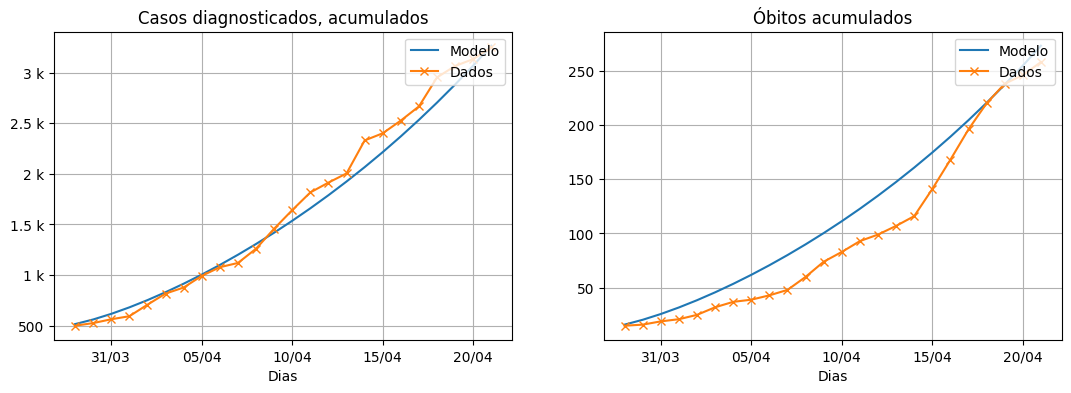

In [16]:
fig, axs = PyPlot.subplots(ncols=2, figsize=(13,4))
datas = [Rio_acc_d,Rio_acc_m]
series = [sol[9,:],sol[10,:]]
axs[1].set_title("Casos diagnosticados, acumulados")
axs[2].set_title("Óbitos acumulados")
for (ax,serie,data) in zip(axs,series,datas)
    graph_py.plot_accum(serie, data,real_data = true, ax = ax,blur = 1.0, cor_serie = "C0", cor_dados = "C1x-")
end

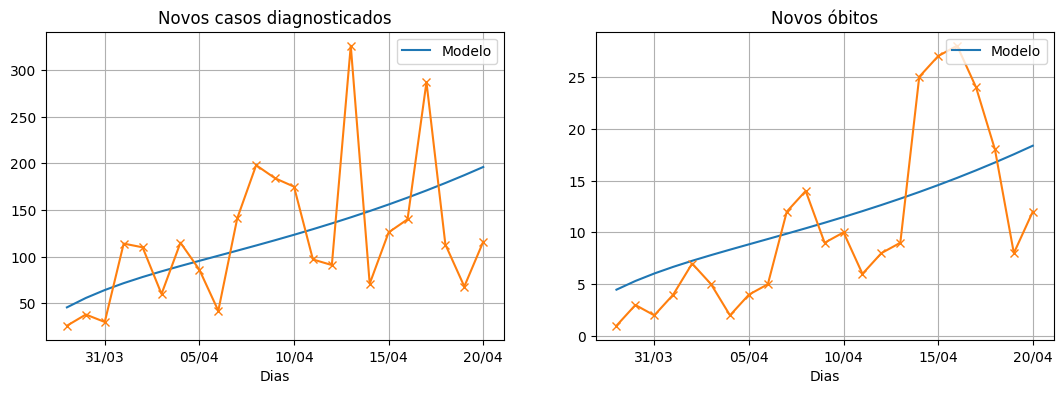

In [17]:
fig, axs = PyPlot.subplots(ncols=2, figsize=(13,4))
datas = [diagn_Rio,obitos_Rio]
series = [sol[9,:],sol[10,:]]
axs[1].set_title("Novos casos diagnosticados")
axs[2].set_title("Novos óbitos")
for (ax,serie,data) in zip(axs,series,datas)
    graph_py.plot_daily(serie, data,real_data = true, ax = ax, cor_serie = "C0", cor_dados = "C1x-")
end

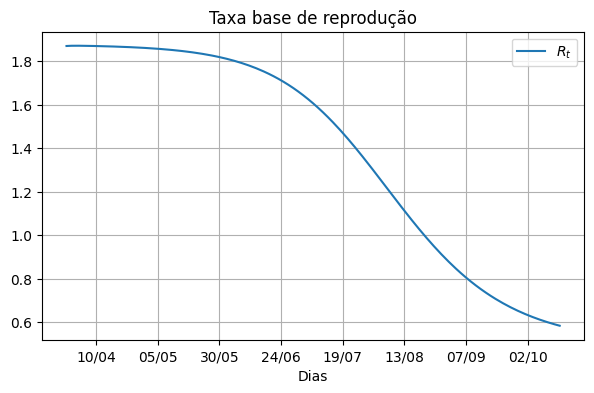

In [18]:
Ts = 0.0:1.0:200
CI_opt, p_opt = build_p_ci(res.minimizer)
sol = model(p_opt, CI_opt, Ts);
fig, ax = PyPlot.subplots(ncols=1, figsize=(7,4))
serie = Rt(sol,p_opt)
ax.set_title("Taxa base de reprodução")
graph_py.plot_accum(serie, Rio_acc_d,real_data = false, label = L"R_t", ax = ax,blur = 1.0, eng_fmt = false)

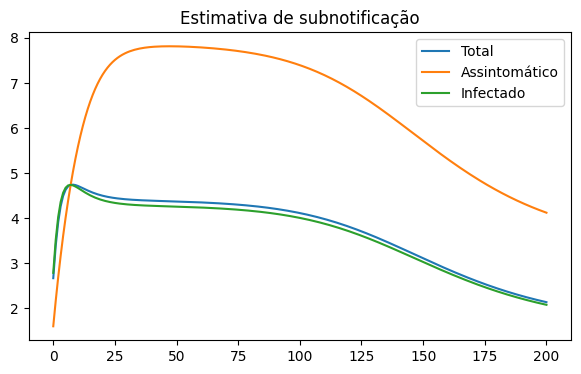

In [19]:
fig, ax = PyPlot.subplots(ncols=1, figsize=(7,4))
series_subnot = [(sol[4,:].+sol[5,:])./(sol[6,:].+sol[7,:]),(sol[4,:])./(sol[6,:]),(sol[5,:])./(sol[7,:])]
m_labels = ["Total", "Assintomático", "Infectado"]
ax.set_title("Estimativa de subnotificação")
for (serie,label) in zip(series_subnot,m_labels)
    ax.plot(serie, label = label)
end
ax.legend();

## Variação dos parametros

In [20]:
min_arrs = build_params_variations(res);

In [21]:
possibilities, hr_poss = build_possibilities(min_arrs);

In [22]:
num_series(possibilities)

22932

In [23]:
@time series = prob_adjust(model, (a,b) -> 1, res -> likelihood(res, σ=1e5), param_range(possibilities));

 12.514750 seconds (14.53 M allocations: 2.184 GiB, 8.42% gc time)


In [24]:
idxs = Random.rand(1:length(series), 2000);
idxs = collect(1:1:length(series));

In [25]:
diagn_samples = (hcat([series[j][1]["res"][9,1:24] for j in idxs]...))
death_samples = (hcat([series[j][1]["res"][10,1:24] for j in idxs]...));

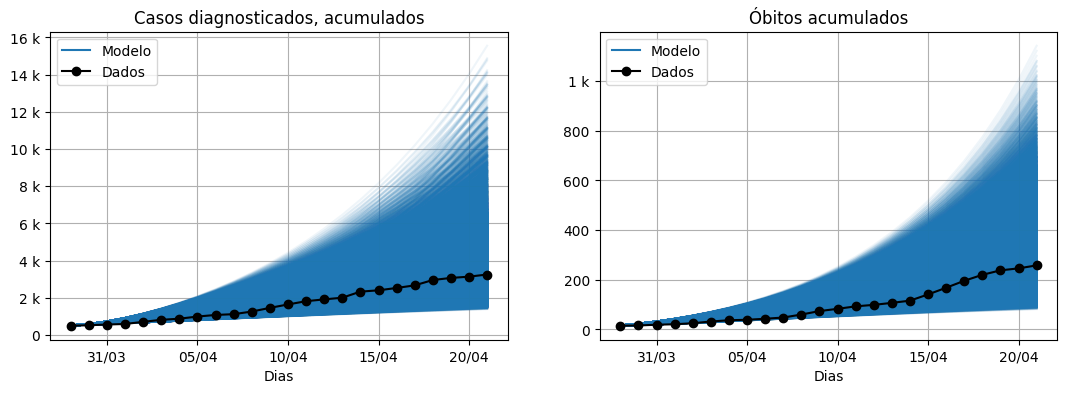

In [26]:
fig, axs = PyPlot.subplots(ncols=2, figsize=(13,4))
datas = [Rio_acc_d,Rio_acc_m]
models = [diagn_samples,death_samples]
axs[1].set_title("Casos diagnosticados, acumulados")
axs[2].set_title("Óbitos acumulados")
custom_lines = [ mlines.Line2D([], [], color="C0", label = "Modelo"),
                 mlines.Line2D([], [], color="k", marker = "o", label = "Dados")]
for (ax,data, model) in zip(axs, datas, models)
    graph_py.plot_accum(model, data, real_data = true, label = nothing, ax = ax, blur = 0.07, cor_serie = "C0", cor_dados = "ko-", legend = false)
    ax.legend(handles=custom_lines)
end

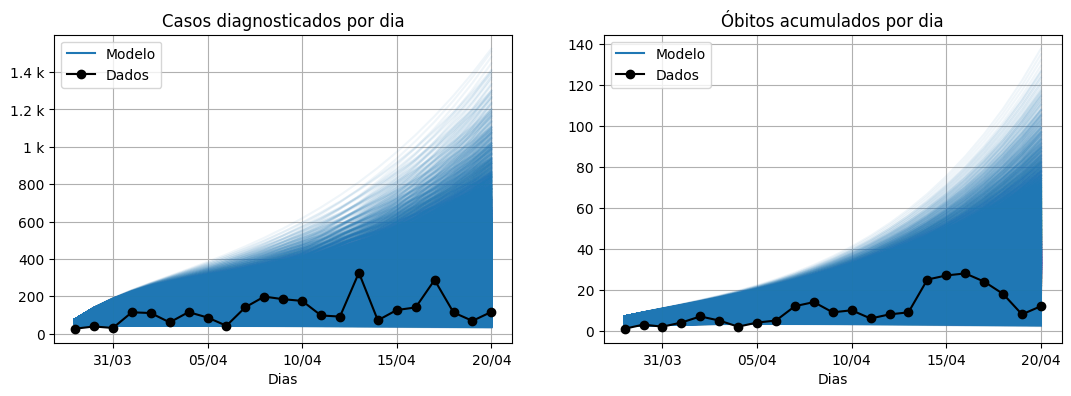

In [27]:
fig, axs = PyPlot.subplots(ncols=2, figsize=(13,4))
datas = [diagn_Rio,obitos_Rio]
models = [diagn_samples,death_samples]
axs[1].set_title("Casos diagnosticados por dia")
axs[2].set_title("Óbitos acumulados por dia")
custom_lines = [ mlines.Line2D([], [], color="C0", label = "Modelo"),
                 mlines.Line2D([], [], color="k", marker = "o", label = "Dados")]
axs[1].legend(custom_lines)
for (ax,data, model) in zip(axs, datas, models)
    graph_py.plot_daily(model, data, real_data = true, label = nothing, ax = ax, blur = 0.07, cor_serie = "C0", cor_dados = "ko-", legend = false)
    ax.legend(handles=custom_lines)
end

In [28]:
diagn_samples = (hcat([series[j][1]["res"][9,1:end] for j in idxs]...))
death_samples = (hcat([series[j][1]["res"][10,1:end] for j in idxs]...));

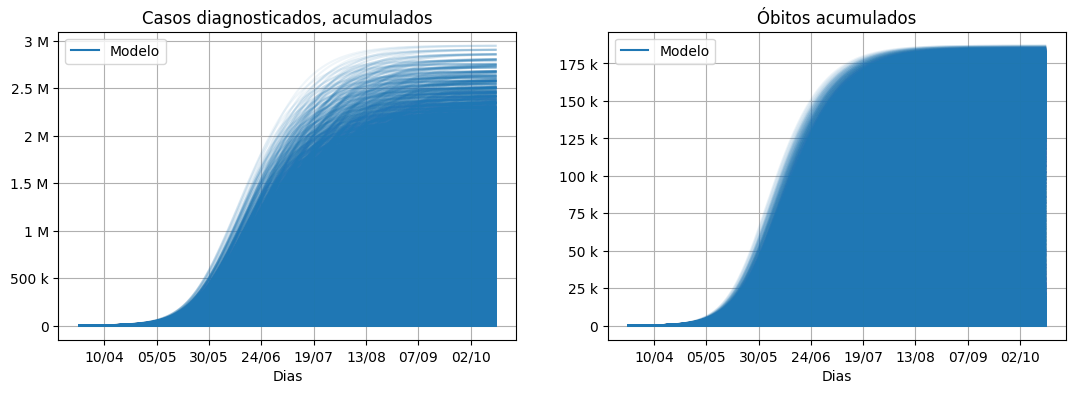

In [29]:
fig, axs = PyPlot.subplots(ncols=2, figsize=(13,4))
datas = [Rio_acc_d,Rio_acc_m]
models = [diagn_samples,death_samples]
axs[1].set_title("Casos diagnosticados, acumulados")
axs[2].set_title("Óbitos acumulados")
custom_lines = [ mlines.Line2D([], [], color="C0", label = "Modelo")]
for (ax,data, model) in zip(axs, datas, models)
    graph_py.plot_accum(model, data, real_data = false, label = nothing, ax = ax, blur = 0.07, cor_serie = "C0", cor_dados = "ko-", legend = false)
    ax.legend(handles=custom_lines)
end

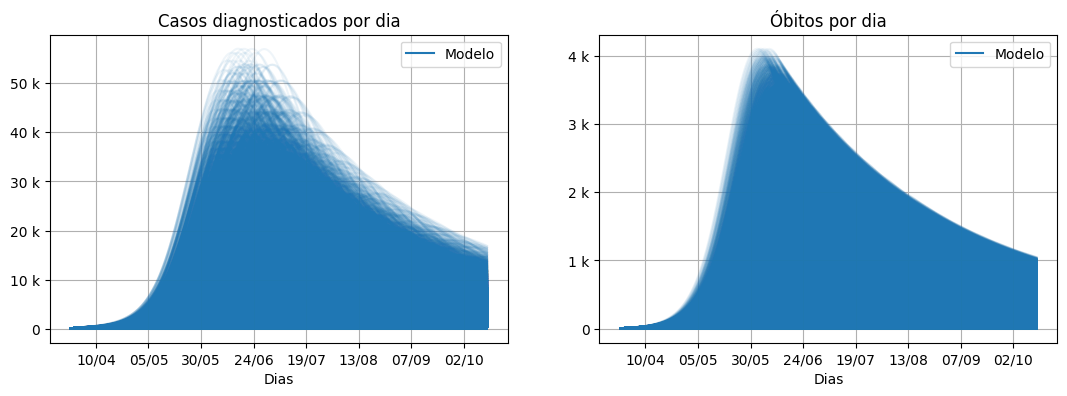

In [30]:
fig, axs = PyPlot.subplots(ncols=2, figsize=(13,4))
datas = [diagn_Rio,obitos_Rio]
models = [diagn_samples,death_samples]
axs[1].set_title("Casos diagnosticados por dia")
axs[2].set_title("Óbitos por dia")
custom_lines = [ mlines.Line2D([], [], color="C0", label = "Modelo")]
axs[1].legend(custom_lines)
for (ax,data, model) in zip(axs, datas, models)
    graph_py.plot_daily(model, data, real_data = false, label = nothing, ax = ax, blur = 0.07, cor_serie = "C0", cor_dados = "ko-", legend = false)
    ax.legend(handles=custom_lines)
end

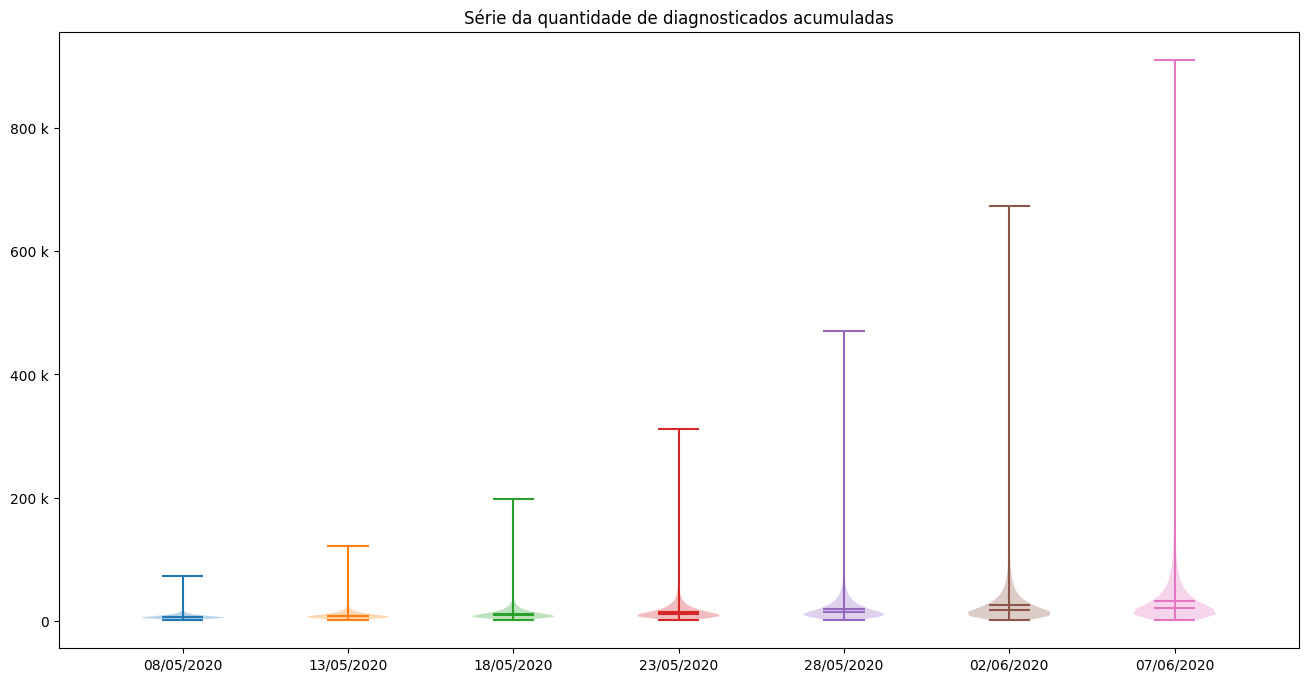

In [31]:
ts = 40:5:70
xs, ws = build_series(series, idxs, ts, index = 9);
fig, ax = plt.subplots(figsize=(16,8))
ax.set_title("Série da quantidade de diagnosticados acumuladas")
graph_py.graph_series(xs,ws,ts,ax)

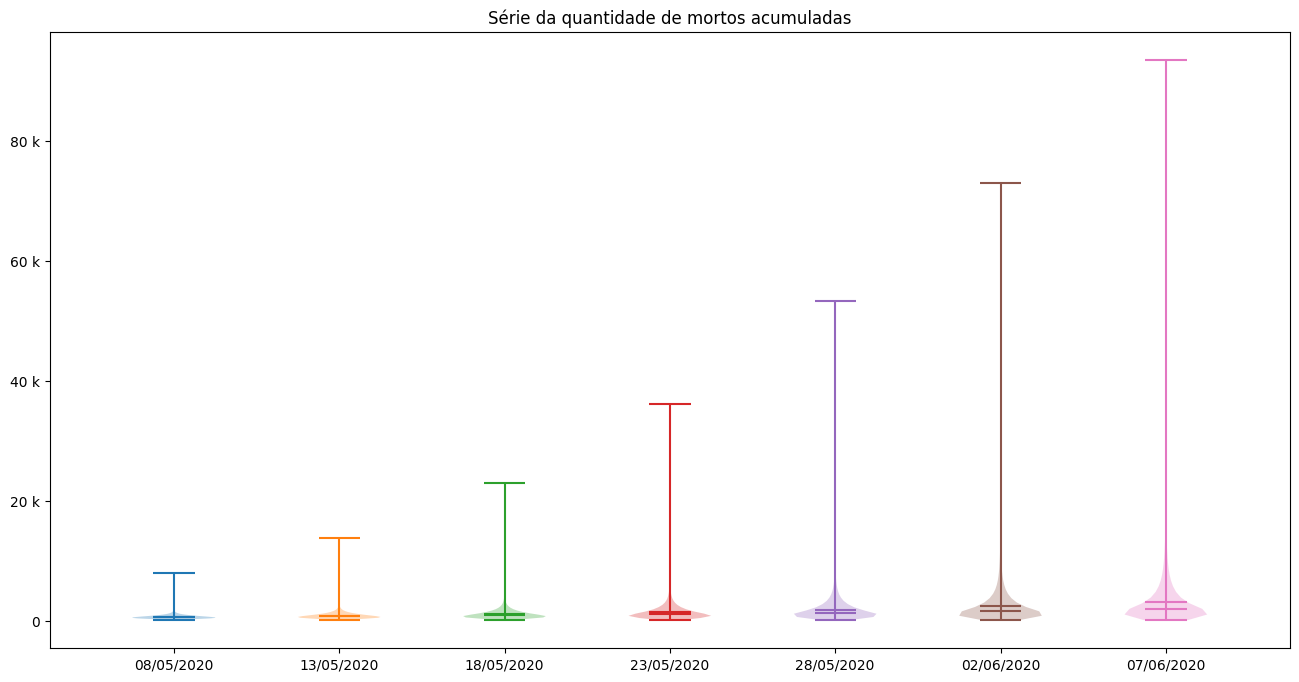

In [32]:
ts = 40:5:70
xs, ws = build_series(series, idxs, ts);
fig, ax = plt.subplots(figsize=(16,8))
ax.set_title("Série da quantidade de mortos acumuladas")
graph_py.graph_series(xs,ws,ts,ax)

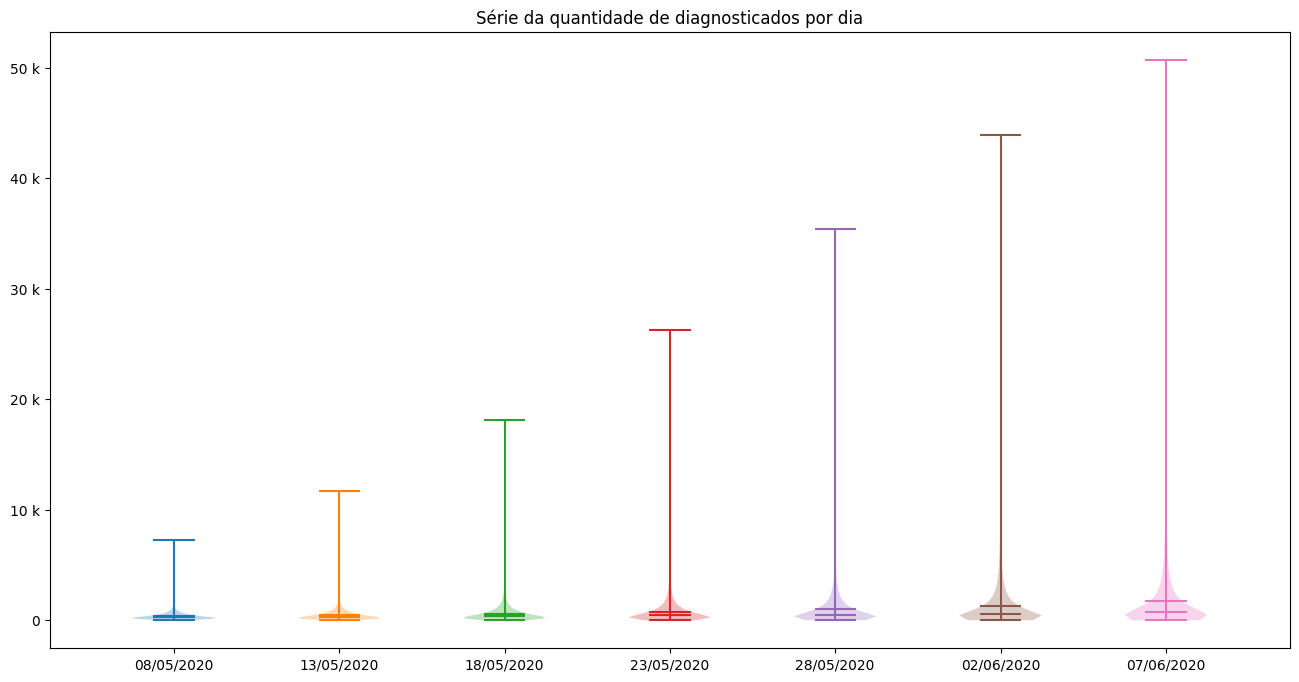

In [33]:
fig, ax = plt.subplots(figsize=(16,8))
ts = 40:5:70
xs,ws = build_series_daily(series, idxs, ts, index = 9)
ax.set_title("Série da quantidade de diagnosticados por dia")
graph_py.graph_series(xs,ws,ts,ax)

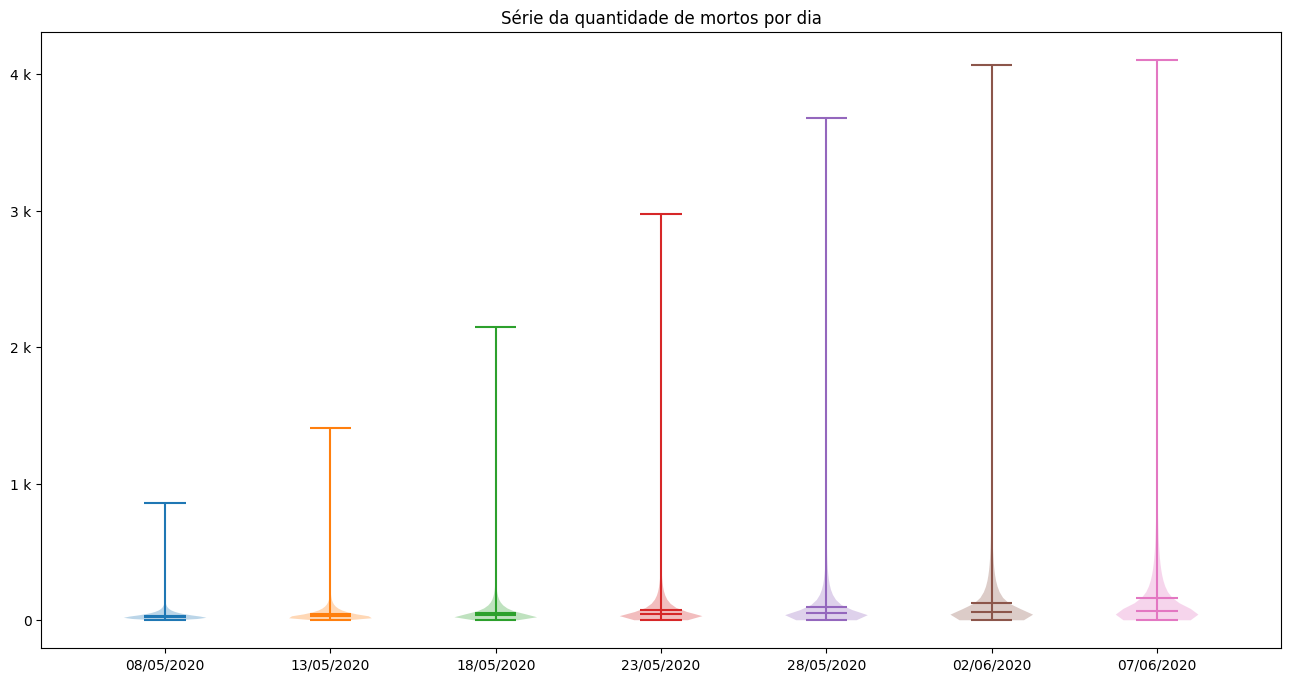

In [34]:
fig, ax = plt.subplots(figsize=(16,8))
ts = 40:5:70
xs,ws = build_series_daily(series, idxs, ts)
ax.set_title("Série da quantidade de mortos por dia")
graph_py.graph_series(xs,ws,ts,ax)

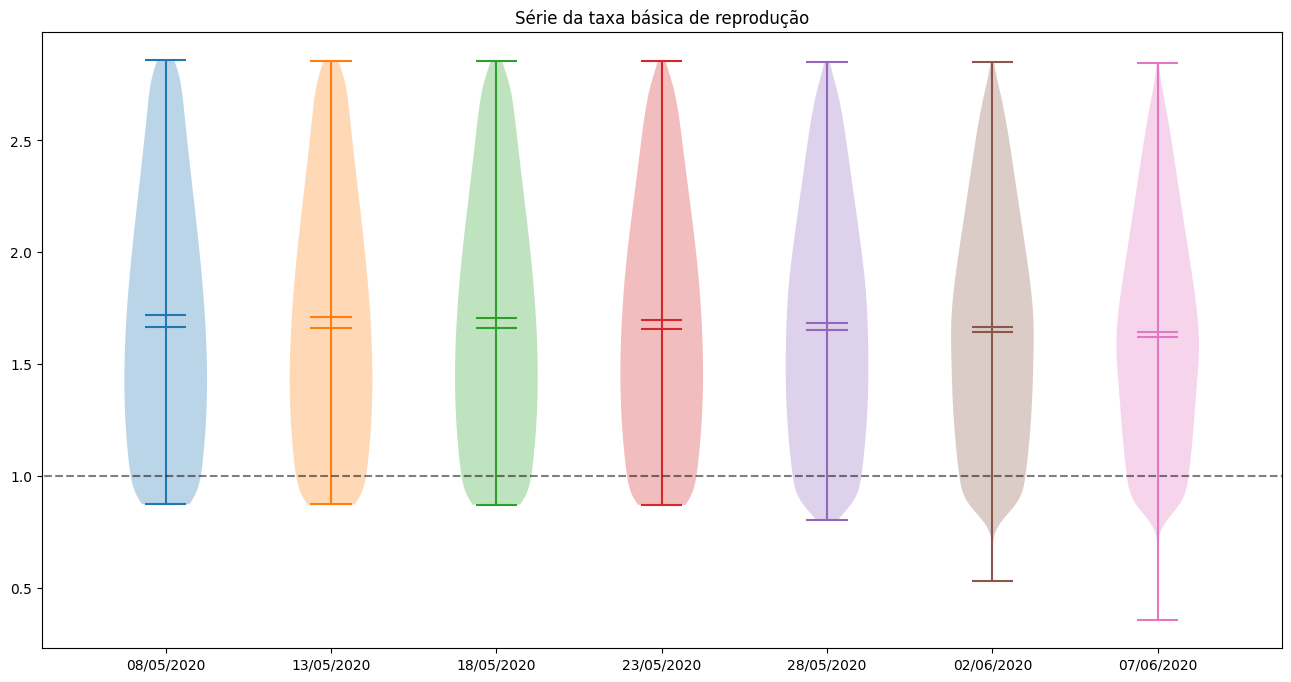

In [35]:
ts = 40:5:70
xs = [[Rt(series[j][1]["res"],p_opt)[t] for j in idxs] for t in ts]
ws = [[series[j][2] for j in idxs] for t in ts];
graph_py.graph_rt(xs,ws,ts)

In [36]:
xs, ws = build_series_parameter(series, "quarentena", day = 40, possibilities, hr_poss, samples = "all", serie = 10);

In [37]:
labels_quarentena = [string(Int(floor(x)))*"%" for x in hr_poss["quarentena"]];
x_label = "Porcentagem de quarentena";

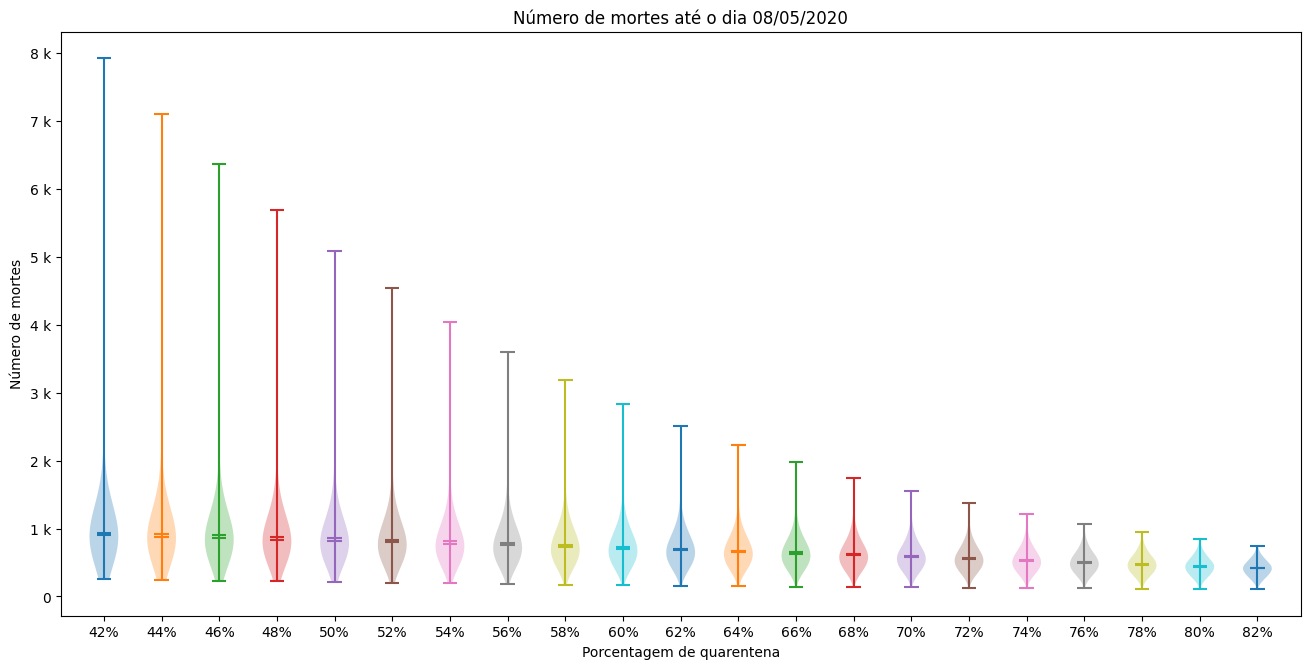

In [38]:
graph_py.graph_deaths(xs,ws,hr_poss["quarentena"],day = 40, labels = labels_quarentena, x_label = x_label, reversed = false)

In [39]:
xs, ws = build_series_parameter(series, "quarentena", day = 50, possibilities, hr_poss, samples = "all");

In [40]:
labels_quarentena = [string(Int(floor(x)))*"%" for x in hr_poss["quarentena"]];
x_label = "Porcentagem de quarentena";

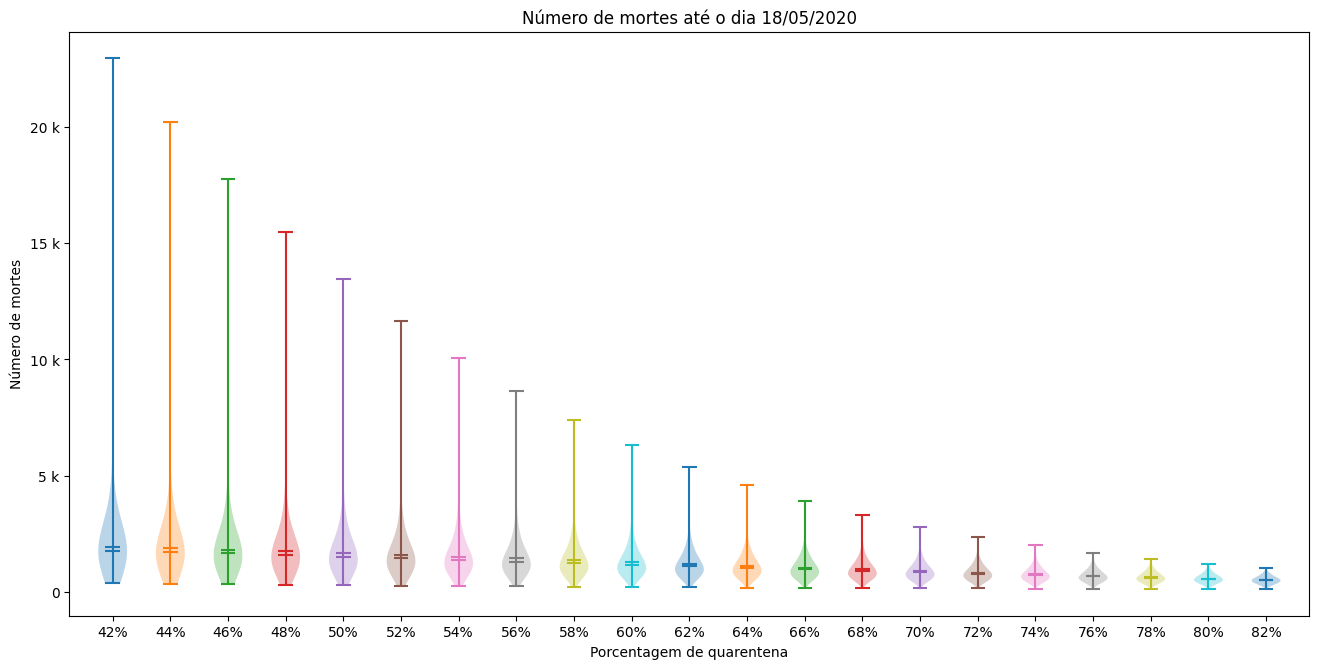

In [41]:
graph_py.graph_deaths(xs,ws,hr_poss["quarentena"],day = 50, labels = labels_quarentena, x_label = x_label, reversed = false)

In [42]:
xs, ws = build_series_parameter(series, "taxa_teste_a", day = 40, possibilities, hr_poss, samples = "all");

In [43]:
labels_quarentena = [Int(floor(x)) for x in hr_poss["taxa_teste_a"]];
x_label = "Taxa de testagem de assintomáticos (dias)";

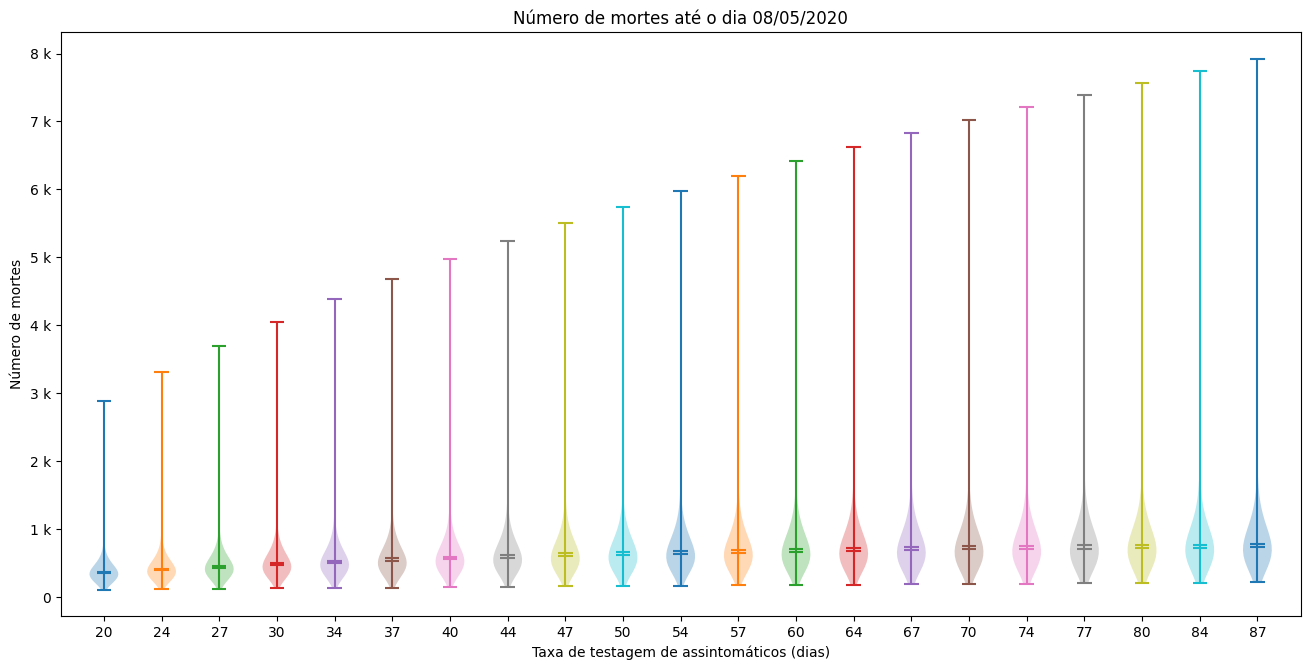

In [44]:
graph_py.graph_deaths(xs,ws,hr_poss["taxa_teste_a"],day = 40, labels = labels_quarentena, x_label = x_label, reversed = false)

In [45]:
xs, ws = build_series_parameter(series, "taxa_teste_a", day = 50, possibilities, hr_poss, samples = "all");

In [46]:
labels_quarentena = [Int(floor(x)) for x in hr_poss["taxa_teste_a"]];
x_label = "Taxa de testagem de assintomáticos (dias)";

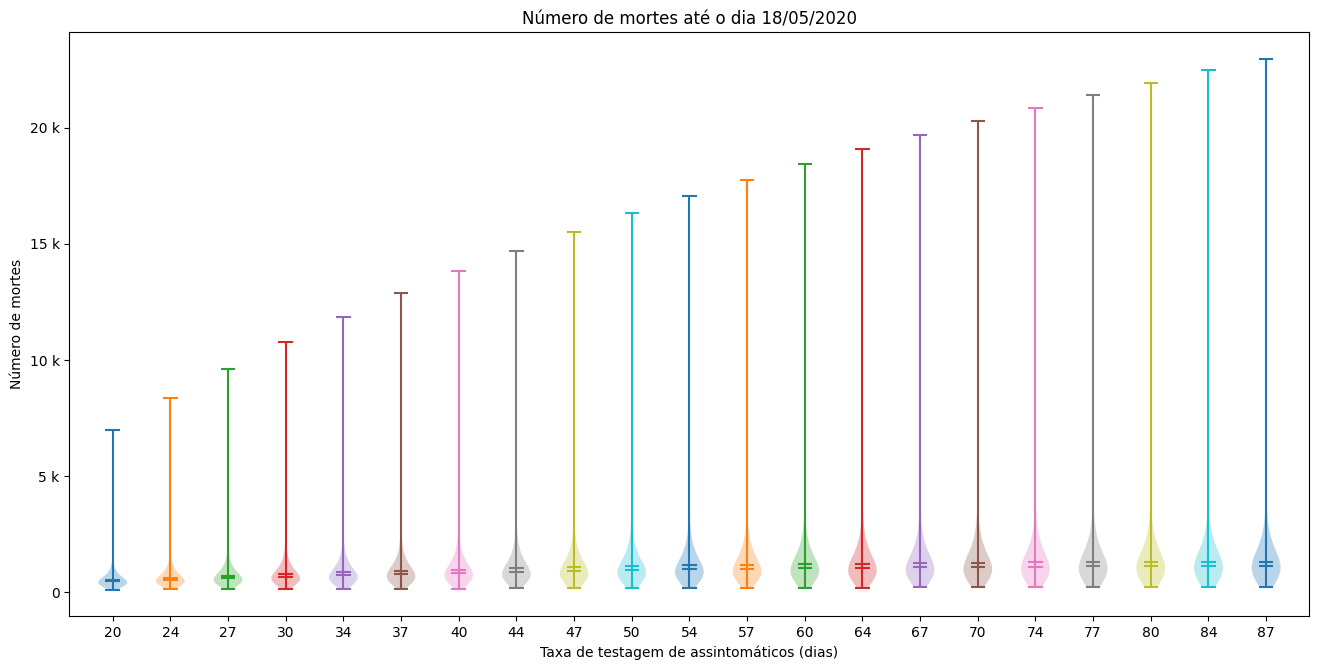

In [47]:
graph_py.graph_deaths(xs,ws,hr_poss["taxa_teste_a"],day = 50, labels = labels_quarentena, x_label = x_label, reversed = false)

In [48]:
xs, ws = build_series_parameter(series, "taxa_teste_i", day = 40, possibilities, hr_poss, samples = "all");

In [49]:
labels_quarentena = [Int(floor(x)) for x in hr_poss["taxa_teste_i"]];
x_label = "Taxa de testagem de infectados (dias)";

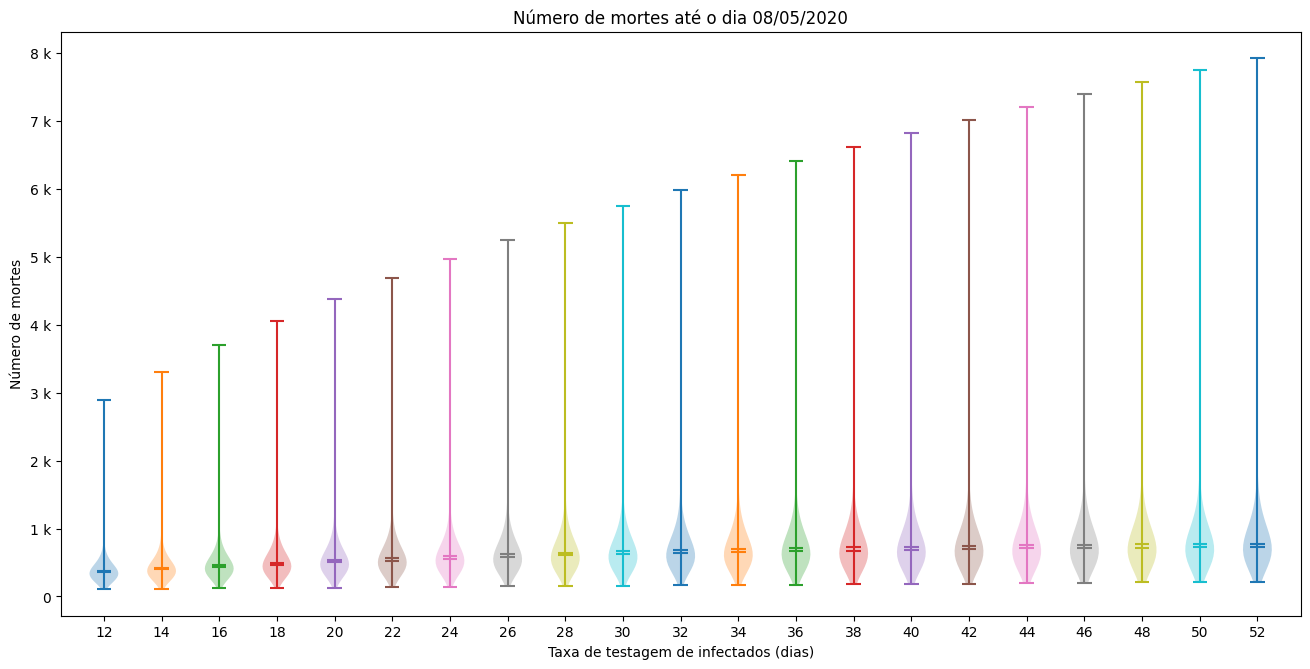

In [50]:
graph_py.graph_deaths(xs,ws,hr_poss["taxa_teste_i"],day = 40, labels = labels_quarentena, x_label = x_label, reversed = false)

In [51]:
xs, ws = build_series_parameter(series, "taxa_teste_i", day = 50, possibilities, hr_poss, samples = "all");

In [52]:
labels_quarentena = [Int(floor(x)) for x in hr_poss["taxa_teste_i"]];
x_label = "Taxa de testagem de infectados (dias)";

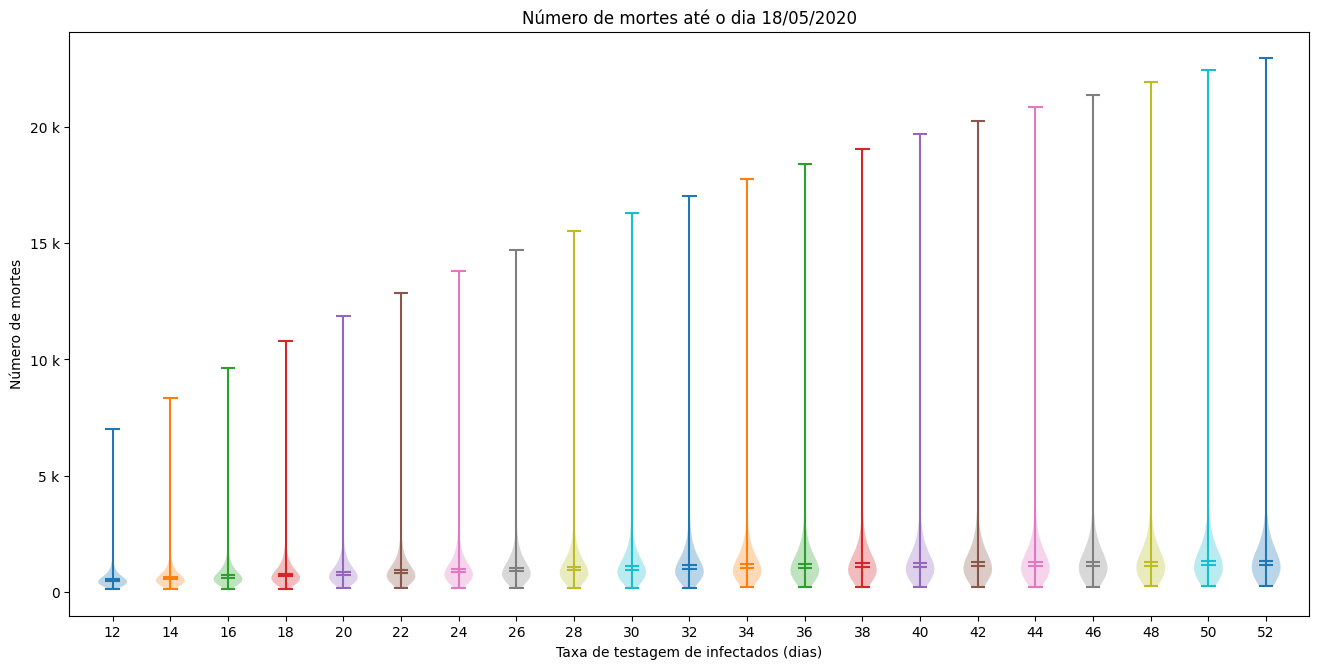

In [53]:
graph_py.graph_deaths(xs,ws,hr_poss["taxa_teste_i"],day = 50, labels = labels_quarentena, x_label = x_label, reversed = false)

In [54]:
using Printf

In [55]:
xs, ws = build_series_parameter(series, "taxa_contagio", day = 50, possibilities, hr_poss, samples = "all");

In [56]:
labels_quarentena = [@sprintf "%1.3f" x*CI_opt[1] for x in hr_poss["taxa_contagio"]];
x_label = "Taxa de contágio";

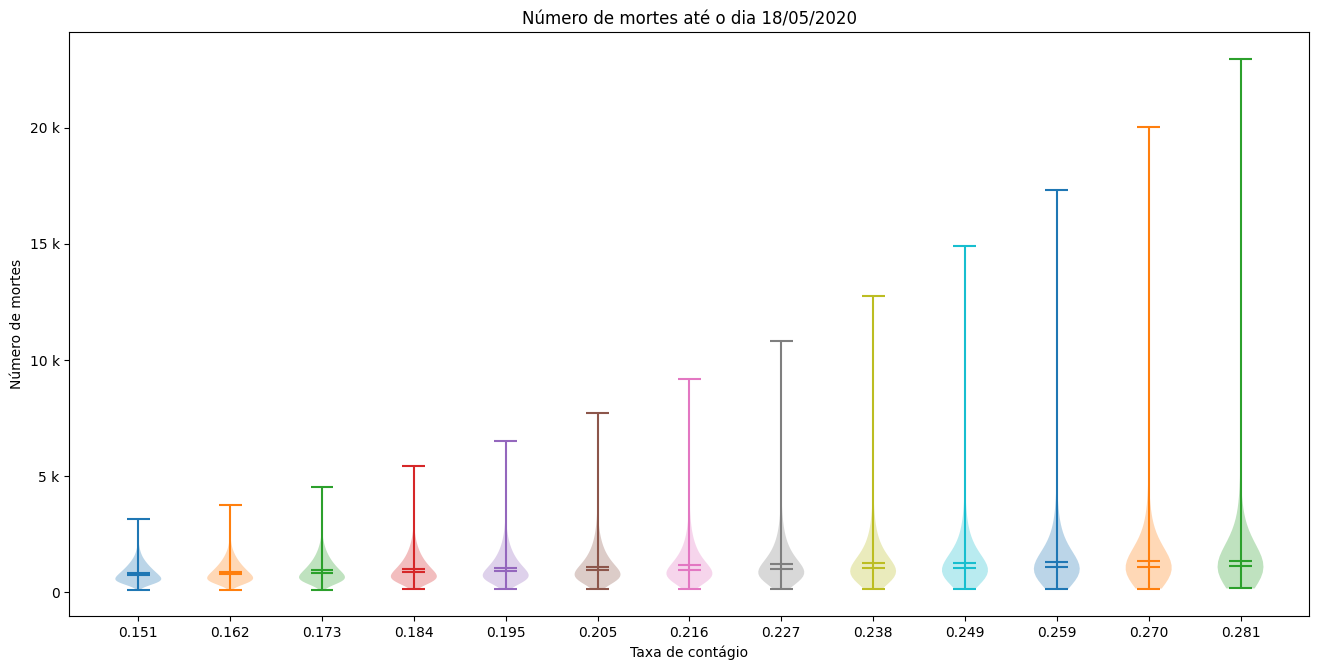

In [57]:
graph_py.graph_deaths(xs,ws,hr_poss["taxa_contagio"],day = 50, labels = labels_quarentena, x_label = x_label, reversed = false)

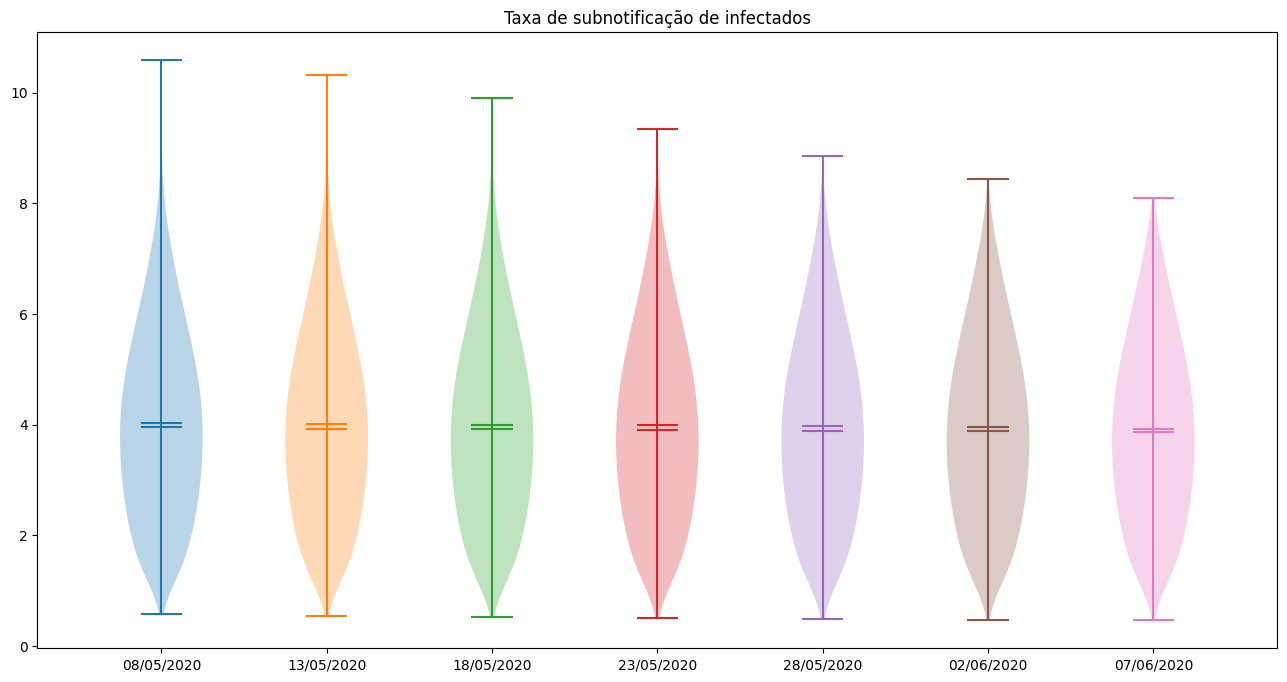

In [58]:
fig, ax = plt.subplots(figsize=(16,8))
ts = 40:5:70
xs,ws = build_series_subnot_infec(series, idxs, ts)
ax.set_title("Taxa de subnotificação de infectados")
graph_py.graph_series(xs,ws,ts,ax)

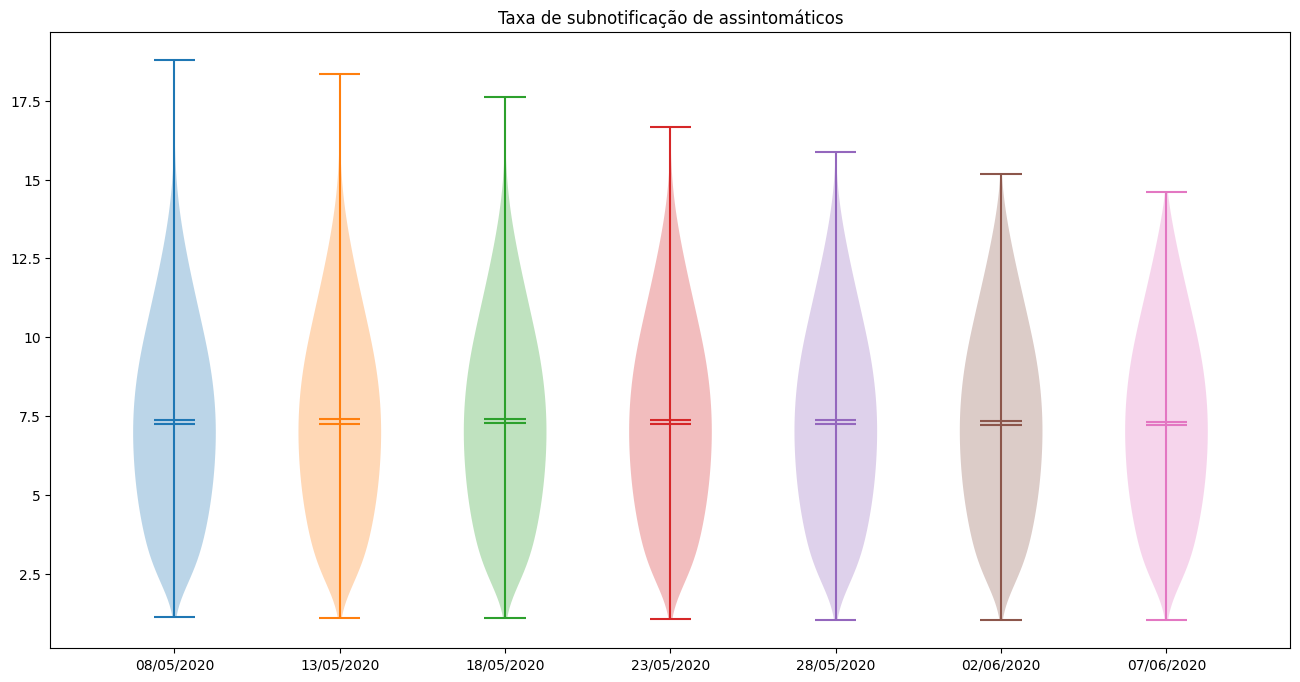

In [59]:
fig, ax = plt.subplots(figsize=(16,8))
ts = 40:5:70
xs,ws = build_series_subnot_assint(series, idxs, ts)
ax.set_title("Taxa de subnotificação de assintomáticos")
graph_py.graph_series(xs,ws,ts,ax)